# Spike Response Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class SRM:
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size,
                 threshold=10.0,
                 eta_reset=10.0,
                 t_membrane=10.0,
                 t_s=1.0,
                 min_delay=1.0,
                 max_delay=7.0,
                 max_synapses=5):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.threshold = threshold
        self.eta_reset = eta_reset
        self.t_membrane = t_membrane
        self.t_s = t_s
        
        # Number of synapses
        self.k0 = np.random.randint(1, max_synapses + 1, size=input_size)
        self.k1 = np.random.randint(1, max_synapses + 1, size=hidden_size)
        
        # Weights
        self.w1 = np.random.rand(input_size, hidden_size, max_synapses)
        self.w2 = np.random.rand(hidden_size, output_size, max_synapses)
        
        # Delays
        self.d1 = np.random.randint(min_delay, max_delay + 1, size=(input_size, hidden_size, max_synapses))
        self.d2 = np.random.randint(min_delay, max_delay + 1, size=(hidden_size, output_size, max_synapses))
        
        
    def _eta(self, s):
        return -self.eta_reset * np.exp(-s / self.t_membrane) * float(s >= 0)
    
    def _eps(self, s):
        return (np.exp(-s / self.t_membrane) - np.exp(-s / self.t_s))  * float(s >= 0)
    
    def _is_fired(self, u):
        return u >= self.threshold
    
    def _calculate_layer(self, t, n_prev, n, u_prev, u, k_prev, f_prev, f, w, d):
        for i in range(n):
            for t_prev in f[i]:
                u[t, i] += self._eta(t - t_prev)
        
            for j in range(n_prev):
                for t_prev in f_prev[j]:
                    for k in range(k_prev[j]):
                        u[t, i] += w[j, i, k] * self._eps(t - t_prev - d[j, i, k])
    
    def _update_f(self, t, f, u):
        for i in range(len(f)):
            if u[t, i] >= self.threshold:
                f[i].append(t)
    
    def simulate(self, u0, max_t):
        u1 = np.zeros((max_t, self.hidden_size))
        u2 = np.zeros((max_t, self.output_size))
        
        f0 = [[] for _ in range(self.input_size)]
        f1 = [[] for _ in range(self.hidden_size)]
        f2 = [[] for _ in range(self.output_size)]
        
        for t in range(max_t):
            self._calculate_layer(t, self.input_size, self.hidden_size, u0, u1, self.k0, f0, f1, self.w1, self.d1)
            self._calculate_layer(t, self.hidden_size, self.output_size, u1, u2, self.k1, f1, f2, self.w2, self.d2)
            
            self._update_f(t, f0, u0)
            self._update_f(t, f1, u1)
            self._update_f(t, f2, u2)
        
        return u1, u2

In [4]:
def plot(u):
    n = u.shape[1]
    time = np.arange(u.shape[0])
    
    plt.figure(figsize=(15, 2 * n))
    
    for i in range(n):
        plt.subplot(n, 1, i + 1)
        plt.plot(time, u[:, i])
        plt.xlabel('time')
        plt.ylabel('u(t)')
    plt.show()
    

def next_time(rate):
    return -np.log(1.0 - np.random.rand()) / rate


def generate_input(max_t, n, rate):
    u = np.random.rand(max_t, n)
    intervals = (-np.log(1.0 - u) / rate).astype(int)
    indices = np.cumsum(intervals, axis=0) 

    values = np.zeros((max_t, n), dtype=np.float)
    
    for i in range(n):
        indices_ = indices[:, i]
        indices_ = indices_[indices_ < max_t]
        values[indices_, i] = 1
        
    return values

# Experiments

In [5]:
K = 5
MAX_T = 100 * K

In [6]:
pattern1 = generate_input(MAX_T // K, n=20, rate=0.03)
pattern1 = np.concatenate([pattern1 for _ in range(K)])

pattern2 = generate_input(MAX_T // K, n=20, rate=0.06)
pattern2 = np.concatenate([pattern2 for _ in range(K)])

## Experiment with 10 hidden neurons

In [7]:
model = SRM(input_size=20, hidden_size=10, output_size=2)

In [8]:
u0 = model.threshold * pattern1
u1, u2 = model.simulate(u0, MAX_T)

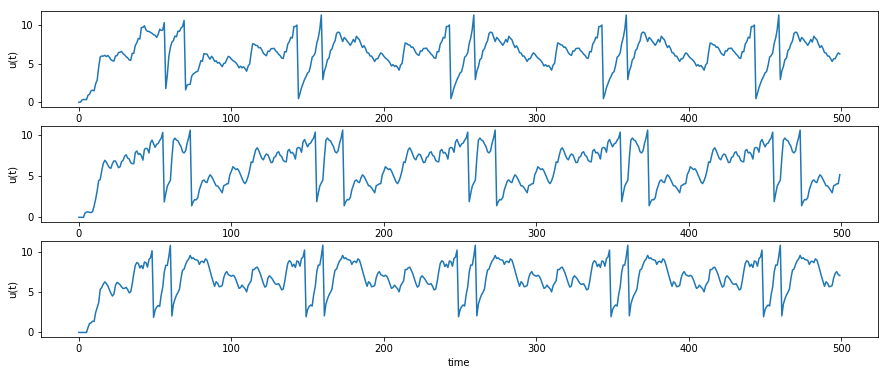

In [9]:
plot(u1[:, :3])

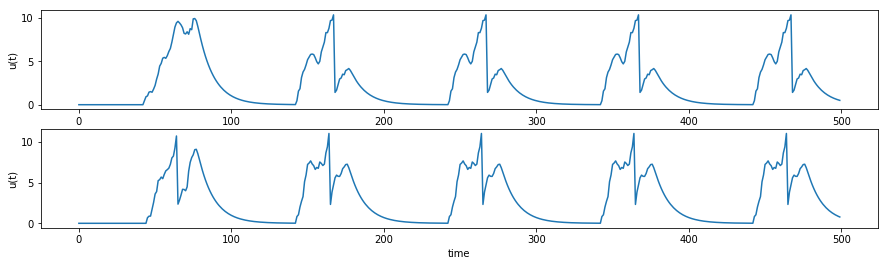

In [10]:
plot(u2)

In [11]:
u0 = model.threshold * pattern2
u1, u2 = model.simulate(u0, MAX_T)

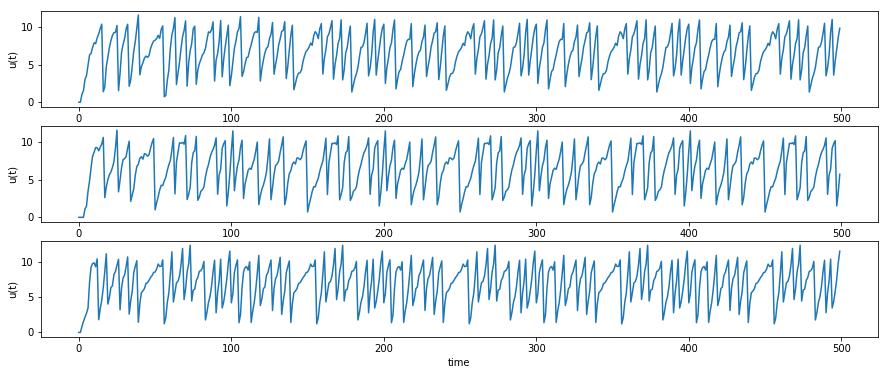

In [12]:
plot(u1[:, :3])

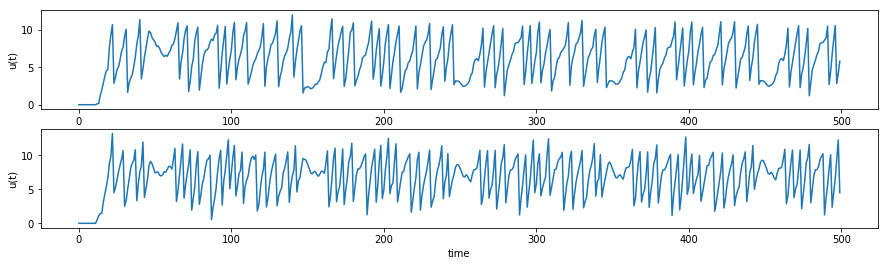

In [13]:
plot(u2)

### Experiment with 20 hidden neurons

In [14]:
model = SRM(input_size=20, hidden_size=20, output_size=2)

In [15]:
u0 = model.threshold * pattern1
u1, u2 = model.simulate(u0, MAX_T)

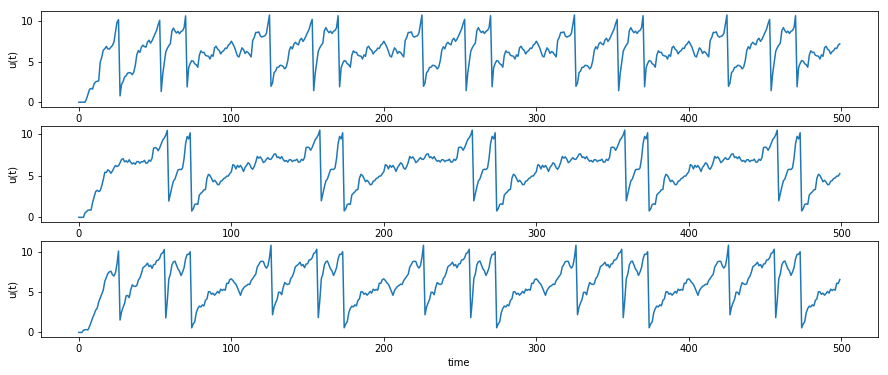

In [16]:
plot(u1[:, :3])

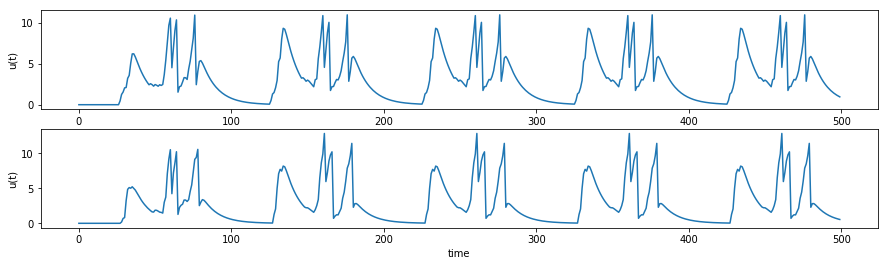

In [17]:
plot(u2)

In [18]:
u0 = model.threshold * pattern2
u1, u2 = model.simulate(u0, MAX_T)

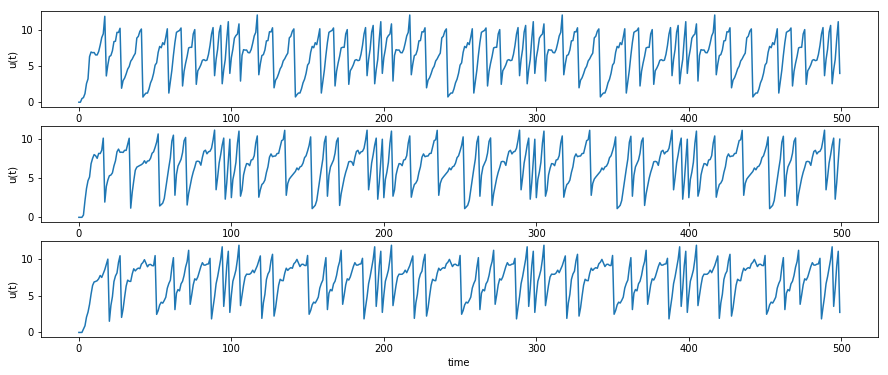

In [19]:
plot(u1[:, :3])

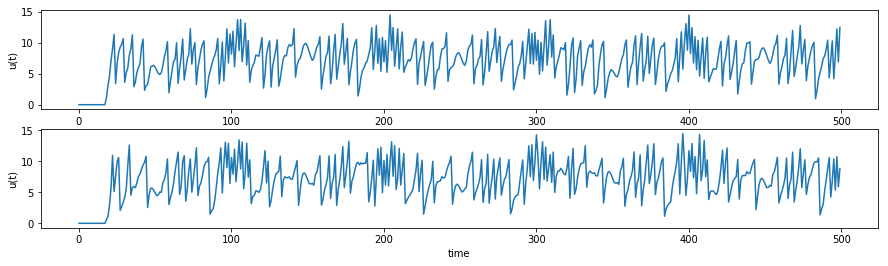

In [20]:
plot(u2)

### Experiment with 50 hidden neurons

In [21]:
model = SRM(input_size=20, hidden_size=50, output_size=2)

In [22]:
u0 = model.threshold * pattern1
u1, u2 = model.simulate(u0, MAX_T)

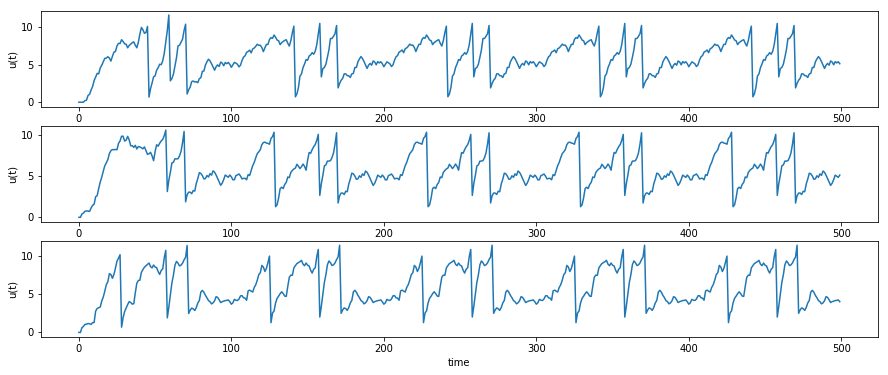

In [23]:
plot(u1[:, :3])

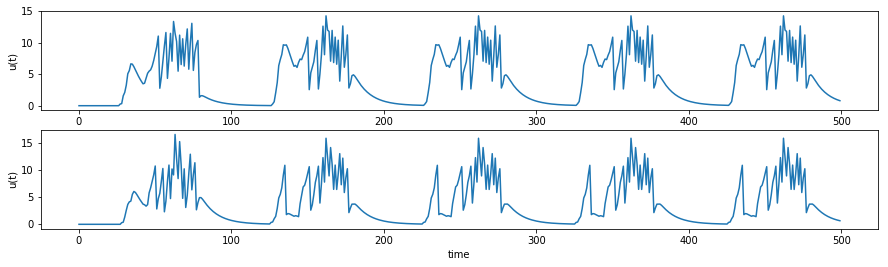

In [24]:
plot(u2)

In [25]:
u0 = model.threshold * pattern2
u1, u2 = model.simulate(u0, MAX_T)

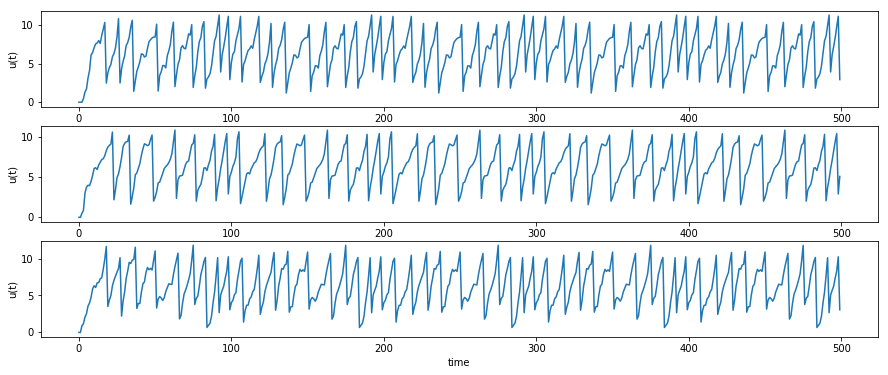

In [26]:
plot(u1[:, :3])

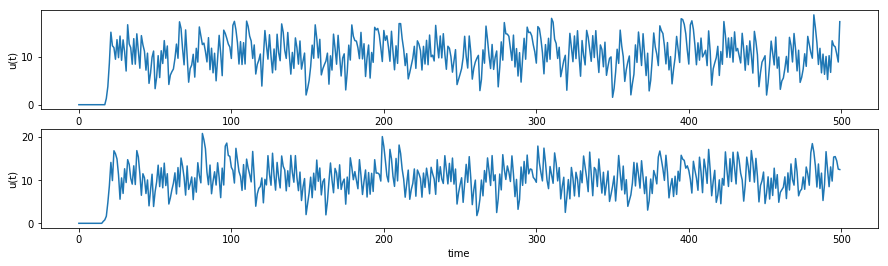

In [27]:
plot(u2)

### Noisy data

In [34]:
def build_patterns(init_pattern):
    patterns = []
    
    # Use 6 stages instead of 11 to speed up the process
    for noise in np.linspace(0, 0.05, 6):
        mask = np.random.binomial(1, noise, size=init_pattern.shape)
        pattern = init_pattern.copy()
        pattern[mask == 1] = 1.0
        patterns.append(pattern)
    
    return patterns

In [35]:
def evaluate(model, patterns):
    results = []
    
    for pattern in patterns:
        u0 = model.threshold * pattern
        results.append(model.simulate(u0, MAX_T))
        
    return results

In [36]:
def get_freqs(spikes):
    freqs = []
    cum_sum = np.cumsum(spikes)

    for size in [10, 15, 20, 25]:
        freq = (cum_sum[size:] - cum_sum[:-size]) / size
        freqs.append(freq)
        
    return freqs

In [37]:
def get_all_freqs(results, threshold):
    freqs = []
    
    for result in results:
        # Select the first neurom from the last layer
        u = result[1][:, 0]
        spikes = u >= threshold
        freqs.append(get_freqs(spikes))
        
    return freqs

In [38]:
def plot_freq(freq):
    plt.plot(list(range(len(freq))), freq)
    plt.ylabel('freq')
    plt.xlabel('time')

In [40]:
model = SRM(input_size=20, hidden_size=10, output_size=2)

In [41]:
patterns1 = build_patterns(pattern1)
results1 = evaluate(model, patterns1)

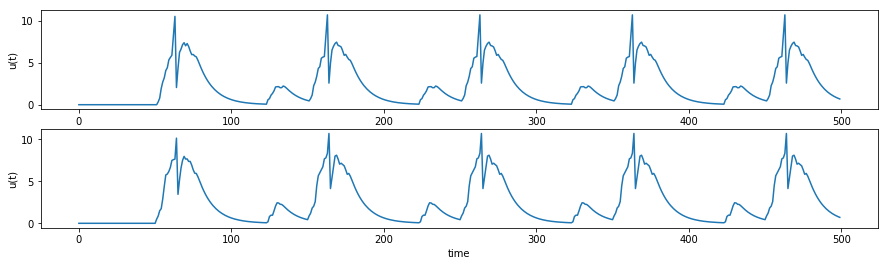

In [42]:
# Noise 0%
plot(results1[0][1])

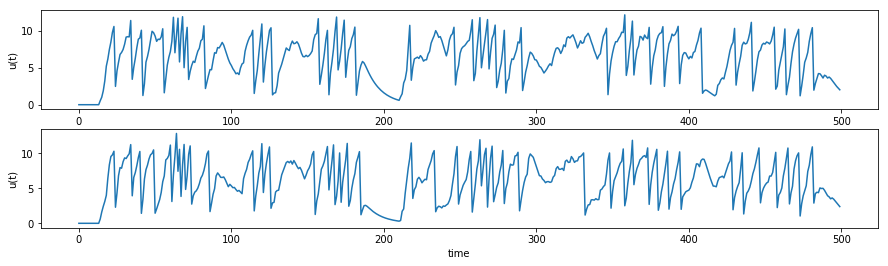

In [44]:
# Noise 3%
plot(results1[3][1])

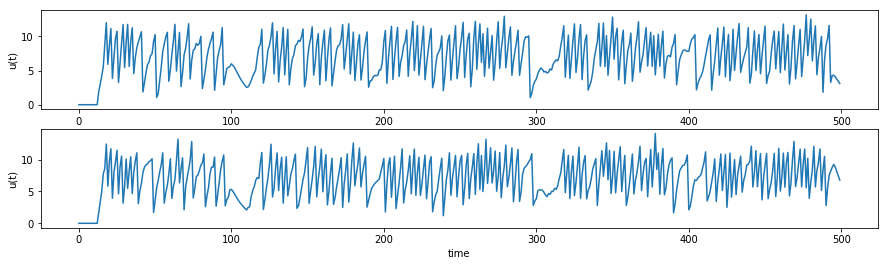

In [45]:
# Noise 5%
plot(results1[5][1])

In [46]:
freqs = get_all_freqs(results1, model.threshold)

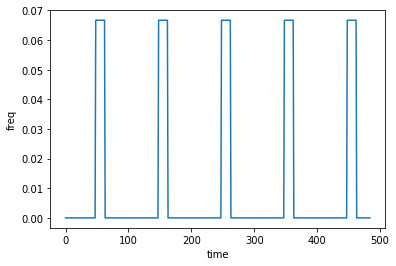

In [47]:
# Noise 0%
plot_freq(freqs[0][1])

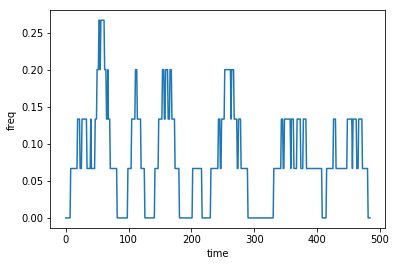

In [50]:
# Noise 3%, window 15ms
plot_freq(freqs[3][1])

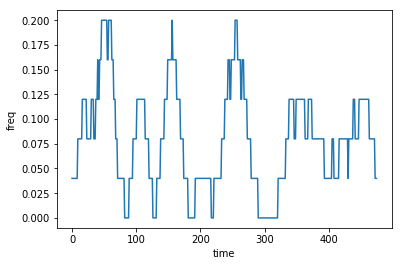

In [60]:
# Noise 3%, window 25ms
plot_freq(freqs[3][3])

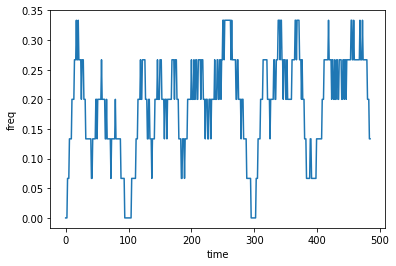

In [51]:
# Noise 5%
plot_freq(freqs[5][1])

In [52]:
patterns2 = build_patterns(pattern2)
results2 = evaluate(model, patterns2)

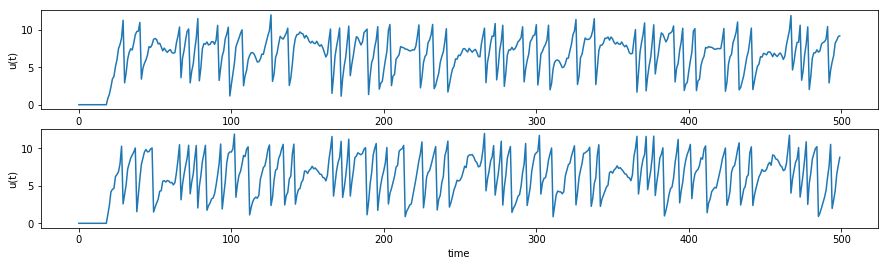

In [53]:
# Noise 0%
plot(results2[0][1])

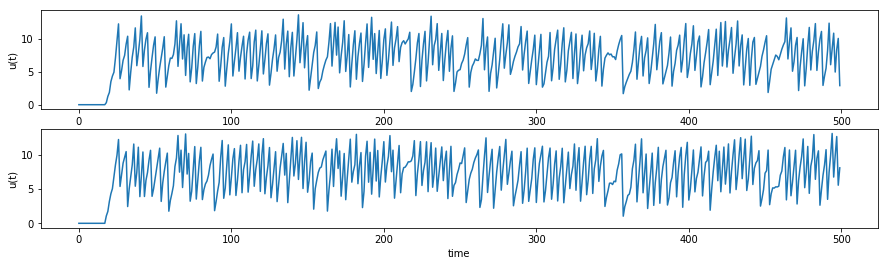

In [54]:
# Noise 3%
plot(results2[3][1])

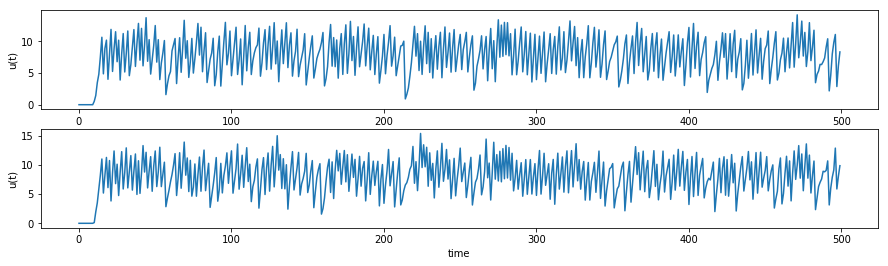

In [55]:
# Noise 5%
plot(results2[5][1])

In [56]:
freqs2 = get_all_freqs(results2, model.threshold)

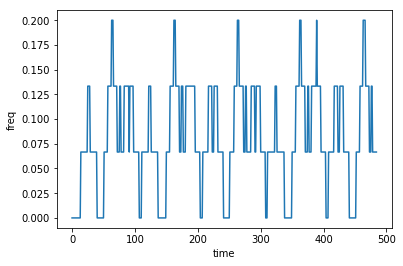

In [57]:
# Noise 0%
plot_freq(freqs2[0][1])

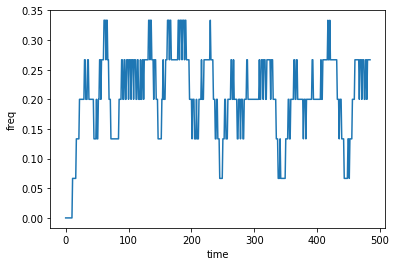

In [58]:
# Noise 3%
plot_freq(freqs2[3][1])

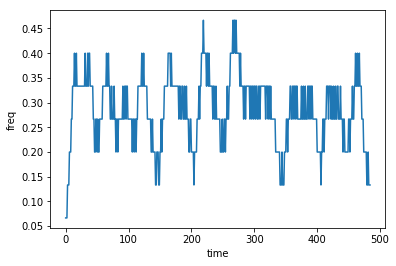

In [59]:
# Noise 5%
plot_freq(freqs2[5][1])